# User Behaviour Analysis Based on Borrowing Dates

The aim of the notebook is to analyze user behavior based on the date of borrowing in order to create a kind of user profile. The following questions should be answered:
1. Do users have a routine when visiting the library? This initially refers to the day of the week on which users borrow items. Can consistency be identified on a particular day?
2. Can a more detailed user type be identified by including the time of day?

In [70]:
%config InlineBackend.figure_format = 'retina'

from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from utils import setup_pandas, setup_plotting


# --- global notebook setup (pandas + tueplots/matplotlib style) ---
setup_pandas()
setup_plotting()


# --- project paths ---
PROCESSED_DATA_PATH = Path('../dat/processed')
CLEANED_FILE = PROCESSED_DATA_PATH / "borrowings_2019_2025_cleaned.csv"


In [71]:
# --- load data ---

borrowings = pd.read_csv(
    CLEANED_FILE,
    sep=";",
    quotechar='"',
    encoding="utf-8"
)

print("Loaded shape:", borrowings.shape)

Loaded shape: (2313072, 21)


In [72]:
# --- preprocess relevant columns ---

# column names
ISSUE_COL = "Ausleihdatum/Uhrzeit"
USER_ID_COL = "Benutzer-Systemnummer"
USER_CATEGORY_COL = "Benutzerkategorie"
LATE_FLAG_COL = "Verspätet"

borrowings[USER_ID_COL] = pd.to_numeric(borrowings[USER_ID_COL], errors="coerce").astype("Int64")
borrowings[ISSUE_COL] = pd.to_datetime(borrowings[ISSUE_COL], errors="coerce")

# normalize late flag to boolean (Ja/Nein -> True/False); keep unknown as <NA> -> not used in this noteboook
if LATE_FLAG_COL in borrowings.columns:
    v = borrowings[LATE_FLAG_COL].astype(str).str.strip().str.lower()
    borrowings["late_bool"] = pd.Series(np.where(v == "ja", True, np.where(v == "nein", False, pd.NA)), dtype="boolean")



### Prepare dataframe for analysis

In [73]:
df_time = borrowings.copy()
df_time = df_time.sort_values(by=[USER_ID_COL, ISSUE_COL])

#  --- create user sessions --- (gap > 30 minutes)
MAX_GAP = pd.Timedelta(minutes=30)

df_time['time_diff'] = df_time.groupby(USER_ID_COL)[ISSUE_COL].diff()
df_time['is_new_session'] = (df_time['time_diff'] > MAX_GAP) | (df_time['time_diff'].isna())
df_time['session_id'] = df_time.groupby(USER_ID_COL)['is_new_session'].cumsum()

# Aggregate to session level
user_sessions = df_time.groupby([USER_ID_COL, 'session_id']).agg({
    ISSUE_COL: 'first',
    USER_CATEGORY_COL: 'first', 
    'late_bool': 'max',
    'is_new_session': 'size'  
}).reset_index()

# Rename and create features for temporal analysis
user_sessions = user_sessions.rename(columns={'is_new_session': 'items_count'})
user_sessions["weekday"] = user_sessions[ISSUE_COL].dt.day_name()
user_sessions["hour"] = user_sessions[ISSUE_COL].dt.hour
user_sessions["seconds_since_midnight"] = (
    user_sessions[ISSUE_COL].dt.hour * 3600 +
    user_sessions[ISSUE_COL].dt.minute * 60 +
    user_sessions[ISSUE_COL].dt.second
)
user_sessions["precise_hour"] = user_sessions["seconds_since_midnight"] / 3600
user_sessions["date"] = user_sessions[ISSUE_COL].dt.date



Clean up data set for analysis:
1. Remove outliers (time = midnight)
2. Remove loans that take place on the main closing days (Monday and Sunday)
3. Filter by users who have made at least MIN_SESSIONS loans

In [74]:
MIN_SESSIONS = 10

# --- Remove midnight outliers ---
midnight_sessions = user_sessions[
    (user_sessions[ISSUE_COL].dt.hour == 0) & 
    (user_sessions[ISSUE_COL].dt.minute == 0) & 
    (user_sessions[ISSUE_COL].dt.second == 0)
]
user_sessions_clean = user_sessions[~(
    (user_sessions[ISSUE_COL].dt.hour == 0) & 
    (user_sessions[ISSUE_COL].dt.minute == 0)
)].copy()

print(f"Sessions at exactly midnight (removed): {len(midnight_sessions)}")


# --- Remove loans on main closing days (Monday and Sunday) ---
closing_day_mask = user_sessions_clean[ISSUE_COL].dt.weekday.isin([0, 6])
closing_day_sessions = user_sessions_clean[closing_day_mask]
user_sessions_clean = user_sessions_clean[~closing_day_mask].copy()

print(f"Sessions on closing days (Monday and Sunday) removed: {len(closing_day_sessions)}")


# --- Filter users with at least MIN_SESSIONS ---
user_counts = user_sessions_clean.groupby(USER_ID_COL).size()
frequent_user = user_counts[user_counts >= MIN_SESSIONS].index
user_sessions_clean = user_sessions_clean[user_sessions_clean[USER_ID_COL].isin(frequent_user)].copy()



user_sessions_clean = user_sessions_clean[user_sessions_clean[USER_ID_COL].isin(frequent_user)].copy()
print(f"Analyzing {len(frequent_user)} users with at least {MIN_SESSIONS} visits and in total {len(user_sessions_clean)} sessions.")


Sessions at exactly midnight (removed): 7
Sessions on closing days (Monday and Sunday) removed: 15203
Analyzing 9417 users with at least 10 visits and in total 395602 sessions.


In [75]:
user_sessions_clean.head()

,Benutzer-Systemnummer,session_id,Ausleihdatum/Uhrzeit,Benutzerkategorie,late_bool,items_count,weekday,hour,seconds_since_midnight,precise_hour,date
6,50,4.0000,2019-01-22 08:27:39,MPA,False,4,Tuesday,8,30459,8.4608,2019-01-22
7,50,5.0000,2019-01-22 12:09:46,MPA,False,2,Tuesday,12,43786,12.1628,2019-01-22
8,50,6.0000,2019-01-24 09:20:58,MPA,False,1,Thursday,9,33658,9.3494,2019-01-24
9,50,7.0000,2019-01-24 10:59:35,MPA,False,2,Thursday,10,39575,10.9931,2019-01-24
10,50,8.0000,2019-01-24 15:07:45,MPA,False,1,Thursday,15,54465,15.1292,2019-01-24


## Analysis of user routine and weekday consistency

Quantify user routine by calculating the distribution of visits across weekdays and identifying the share of visits occurring on the most frequent day (Favorite Day Consistency)


In [76]:
session_day_counts = user_sessions_clean.groupby([USER_ID_COL, 'weekday']).size().unstack(fill_value=0)

# Top-Day-Percentage based on visits
day_consistency = (session_day_counts.max(axis=1) / session_day_counts.sum(axis=1)) * 100

print(f"Based on {len(day_consistency)} users with >= {MIN_SESSIONS} visits.")
print(day_consistency.describe())

Based on 9417 users with >= 10 visits.
count   9,417.0000
mean       38.8038
std        11.9053
min        20.5882
25%        30.4348
50%        36.1111
75%        43.7500
max       100.0000
dtype: float64


In [77]:
session_day_counts.head()

weekday,Friday,Saturday,Thursday,Tuesday,Wednesday
Benutzer-Systemnummer,,,,,
50,131,58,158,263,202
51,2,1,6,6,1
54,51,43,40,48,48
55,39,0,34,48,18
57,35,4,52,67,50



The mean consistency of 38.8% indicates that, on average users perform nearly 40% of their borrowing sessions on their most preferred weekday. Compared to a theoretical random distribution of 20% (assuming 5 opening days), this could suggest a behavioral routine among frequent users

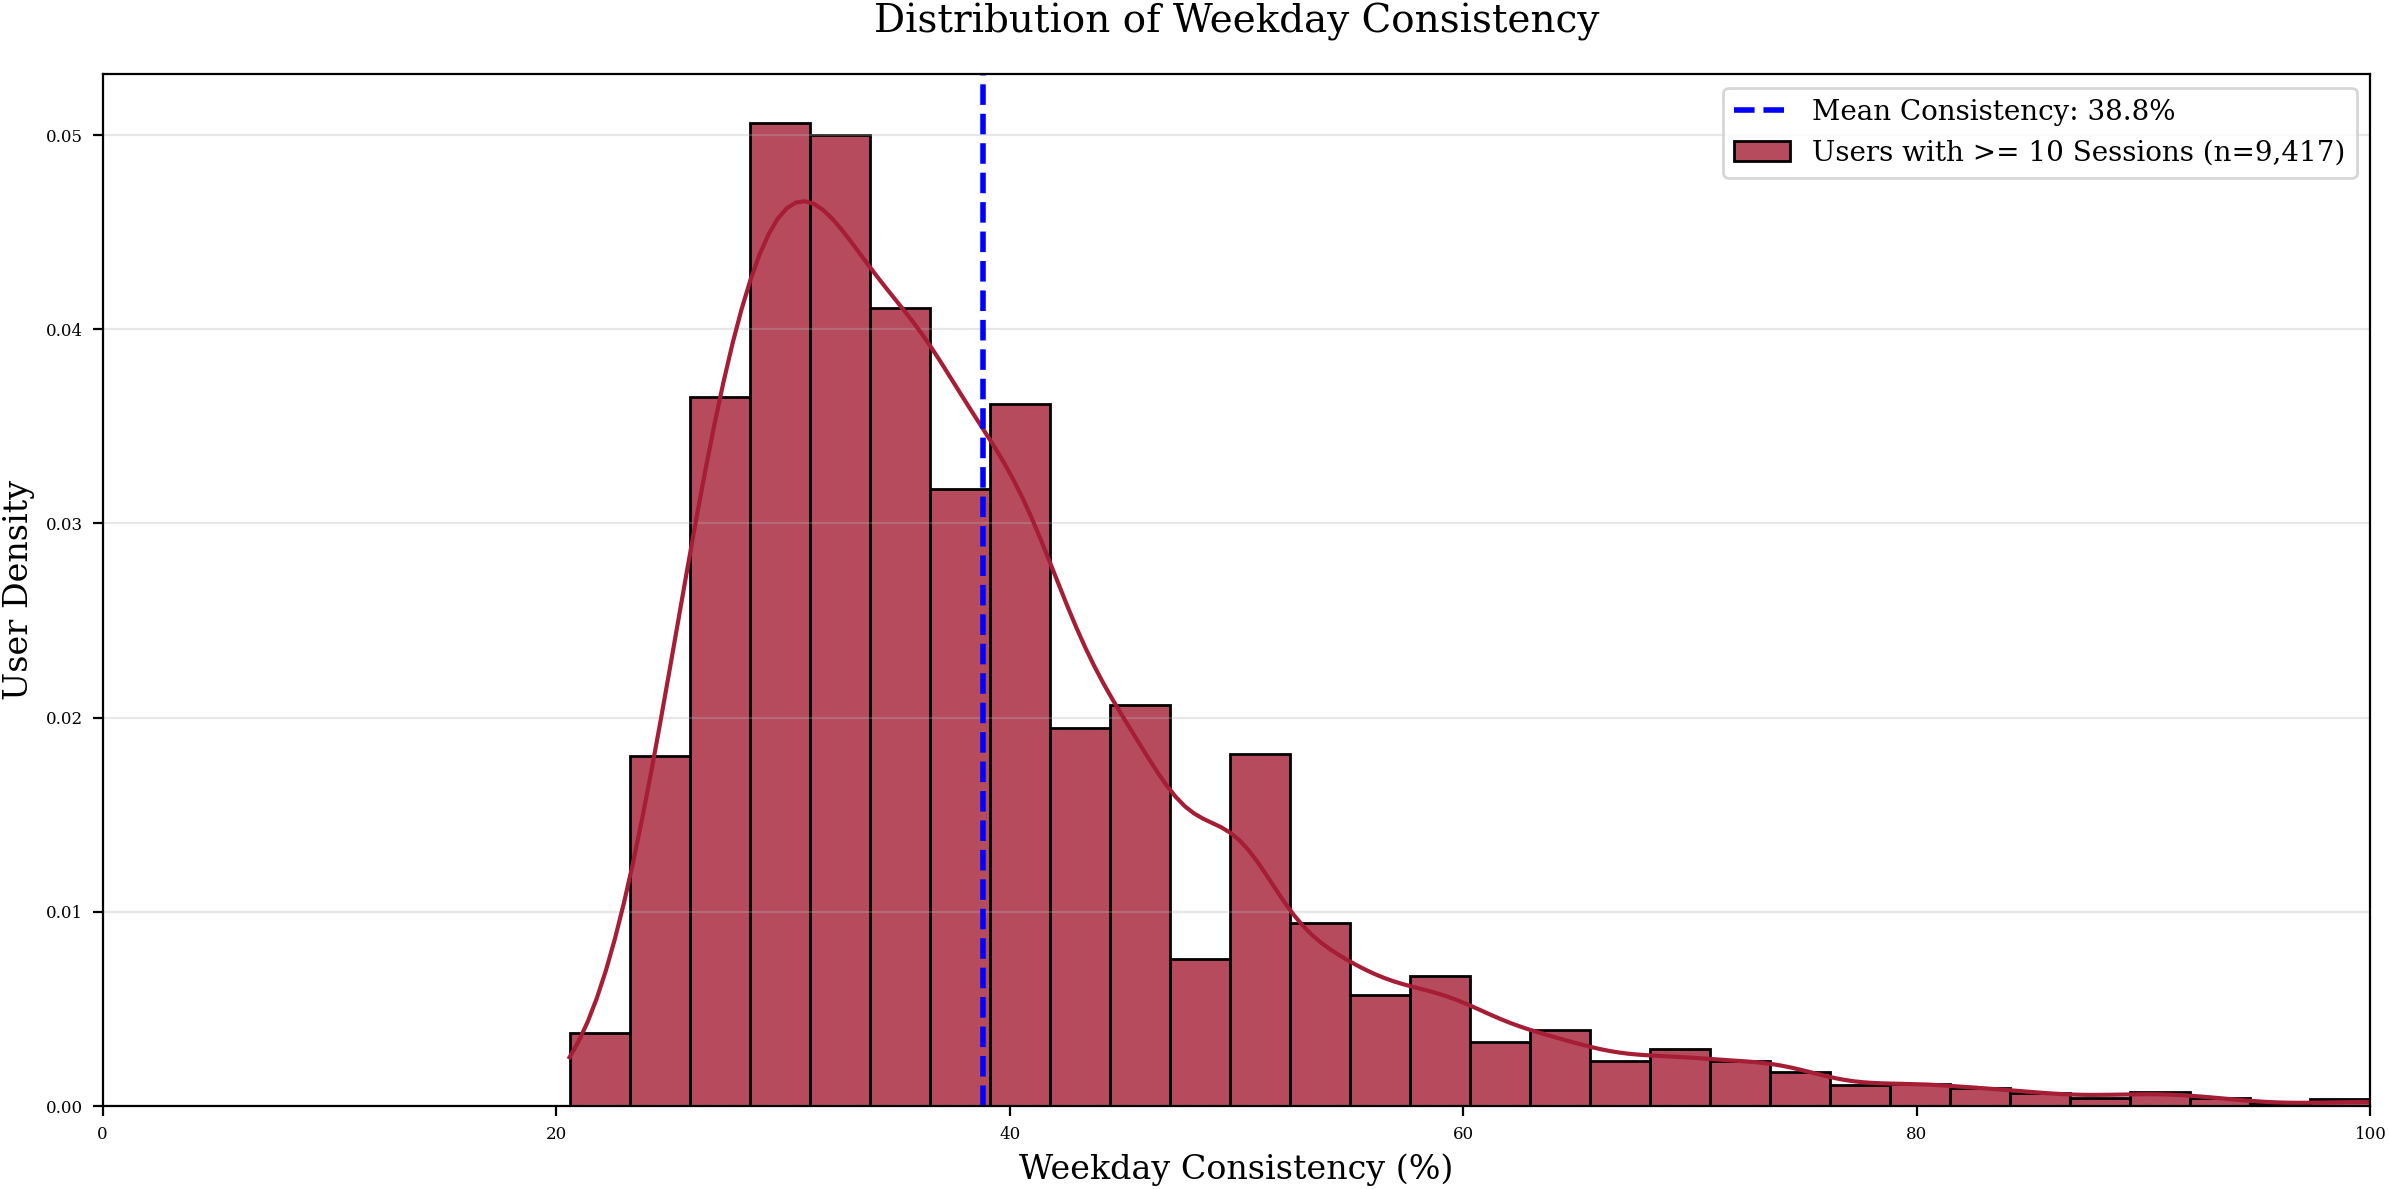

In [78]:

mean_val = day_consistency.mean()

plt.figure(figsize=(12, 6))
sns.histplot(
    day_consistency, 
    bins=30, 
    kde=True, 
    alpha=0.8, 
    label=f'Users with >= {MIN_SESSIONS} Sessions (n={len(day_consistency):,})', 
    stat="density", 
    common_norm=False
)

plt.axvline(
    mean_val, 
    color='blue', 
    linestyle='--', 
    linewidth=2, 
    label=f'Mean Consistency: {mean_val:.1f}%'
)

plt.title('Distribution of Weekday Consistency', fontsize=14, pad=15)
plt.xlabel('Weekday Consistency (%)', fontsize=12)
plt.ylabel('User Density', fontsize=12)
plt.xlim(0, 100)
plt.legend(fontsize=10)
plt.grid(axis='y', alpha=0.3)
plt.show()

### Permutation Test -> Monte Carlo simulation of a uniform weekday borrowing (?)
H0: Users borrow regardless of the day of the week. Each visit is an independent event with probability $p = 1/k$ (where $k$ is the number of opening days).

In [79]:
observed_consistency = (session_day_counts.max(axis=1) / session_day_counts.sum(axis=1)) * 100
observed_mean = observed_consistency.mean()


In [ ]:

N_PERMUTATIONS = 1000
OPEN_DAYS = 5  
visits_per_user = session_day_counts.sum(axis=1).values.astype(int)
num_users = len(visits_per_user)

print(f"Permutation test for {num_users} users \n Users borrow regardless of the day of the week. Each visit is an independent event with probability $p = 1/k$ (where $k$ is the number of opening days).")

permuted_means = np.zeros(N_PERMUTATIONS)
for i in range(N_PERMUTATIONS):
    # Use maximum visit count to build a fixed-size simulation matrix
    max_visits = np.max(visits_per_user)
    # Simulate random weekday borrowing under H0 
    random_matrix = np.random.randint(0, OPEN_DAYS, size=(num_users, max_visits))

    # Mask ensures that users keep their observed number of visits
    mask = np.arange(max_visits) < visits_per_user[:, None]

    # Counts the number of weekdays per row (per user)
    # shape: (OPEN_DAYS, num_users)
    user_counts = np.array([
        np.sum((random_matrix == day) & mask, axis=1)
        for day in range(OPEN_DAYS)
    ])
    #print(user_counts.shape)

    user_max_counts = np.max(user_counts, axis=0)
    user_perm_consistency = (user_max_counts / visits_per_user) * 100
    permuted_means[i] = np.mean(user_perm_consistency)


successes = np.sum(permuted_means >= observed_mean)
p_value= (successes + 1) / (N_PERMUTATIONS + 1)

print(f"Observed mean: {observed_mean:.2f}%")
print(f"Maximum random mean: {max(permuted_means):.2f}%")
print(f"P-value: {p_value}")
if successes == 0:
    print(f"P-Wert: < {p_value:.4f} (No random run reached the observed mean)")
else:
    print(f"P-Wert: {p_value:.4f}")

Permutation test for 9417 users 
 Users borrow regardless of the day of the week. Each visit is an independent event with probability $p = 1/k$ (where $k$ is the number of opening days).
Observed mean: 38.80%
Maximum random mean: 31.08%
P-value: 0.000999000999000999
P-Wert: < 0.0010 (No random run reached the observed mean)


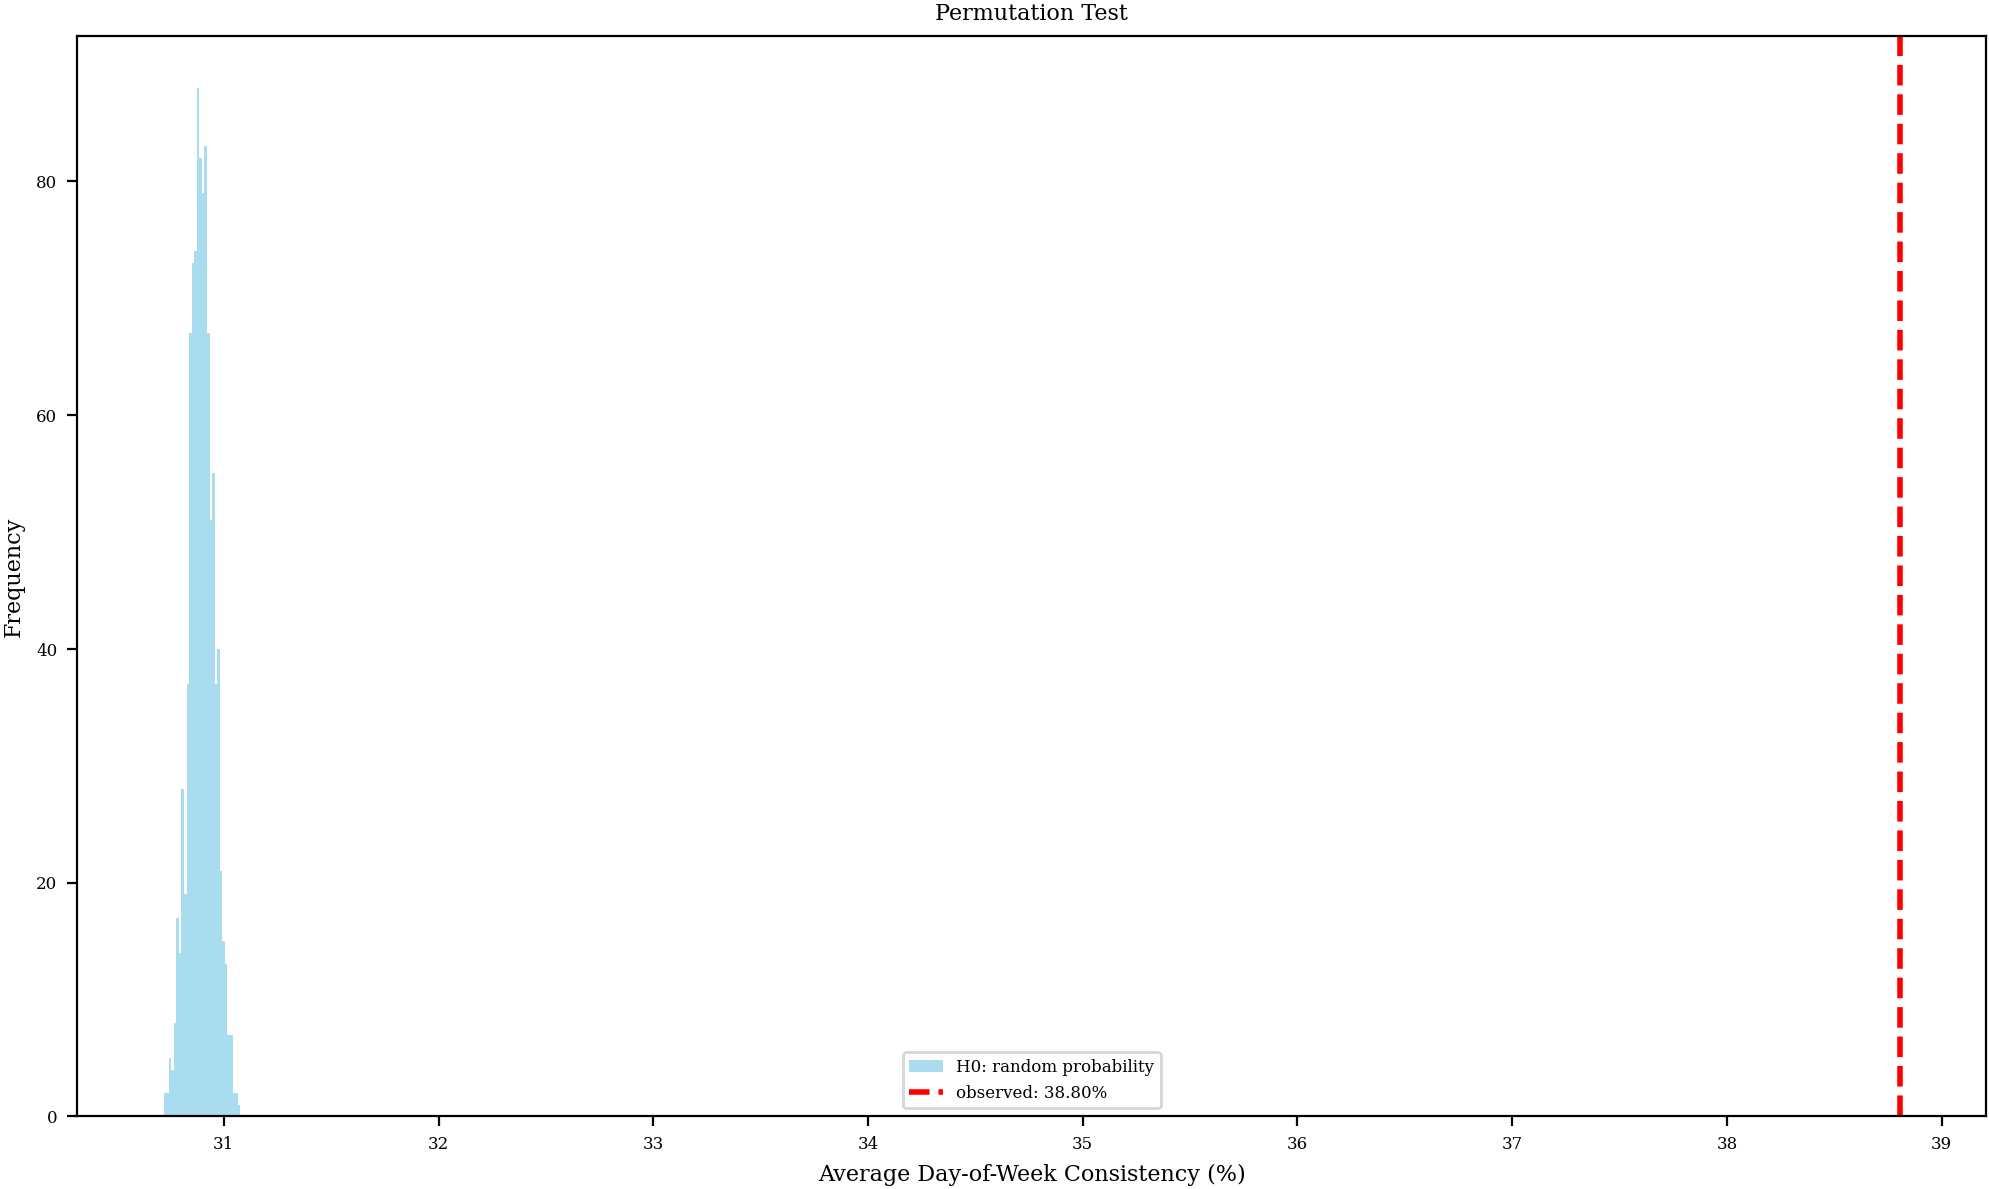

Observed mean: 38.80%
Maximum random mean: 31.08%


In [89]:
plt.figure(figsize=(10, 6))
plt.hist(permuted_means, bins=30, alpha=0.7, color='skyblue', label='H0: random probability')
plt.axvline(observed_mean, color='red', linestyle='--', linewidth=2, label=f'observed: {observed_mean:.2f}%')

plt.title(f"Permutation Test")
plt.xlabel("Average Day-of-Week Consistency (%)")
plt.ylabel("Frequency")
plt.legend()
plt.show()

print(f"Observed mean: {observed_mean:.2f}%")
print(f"Maximum random mean: {max(permuted_means):.2f}%")



## Analysis of borrowing time

### Library usage on a specific day 

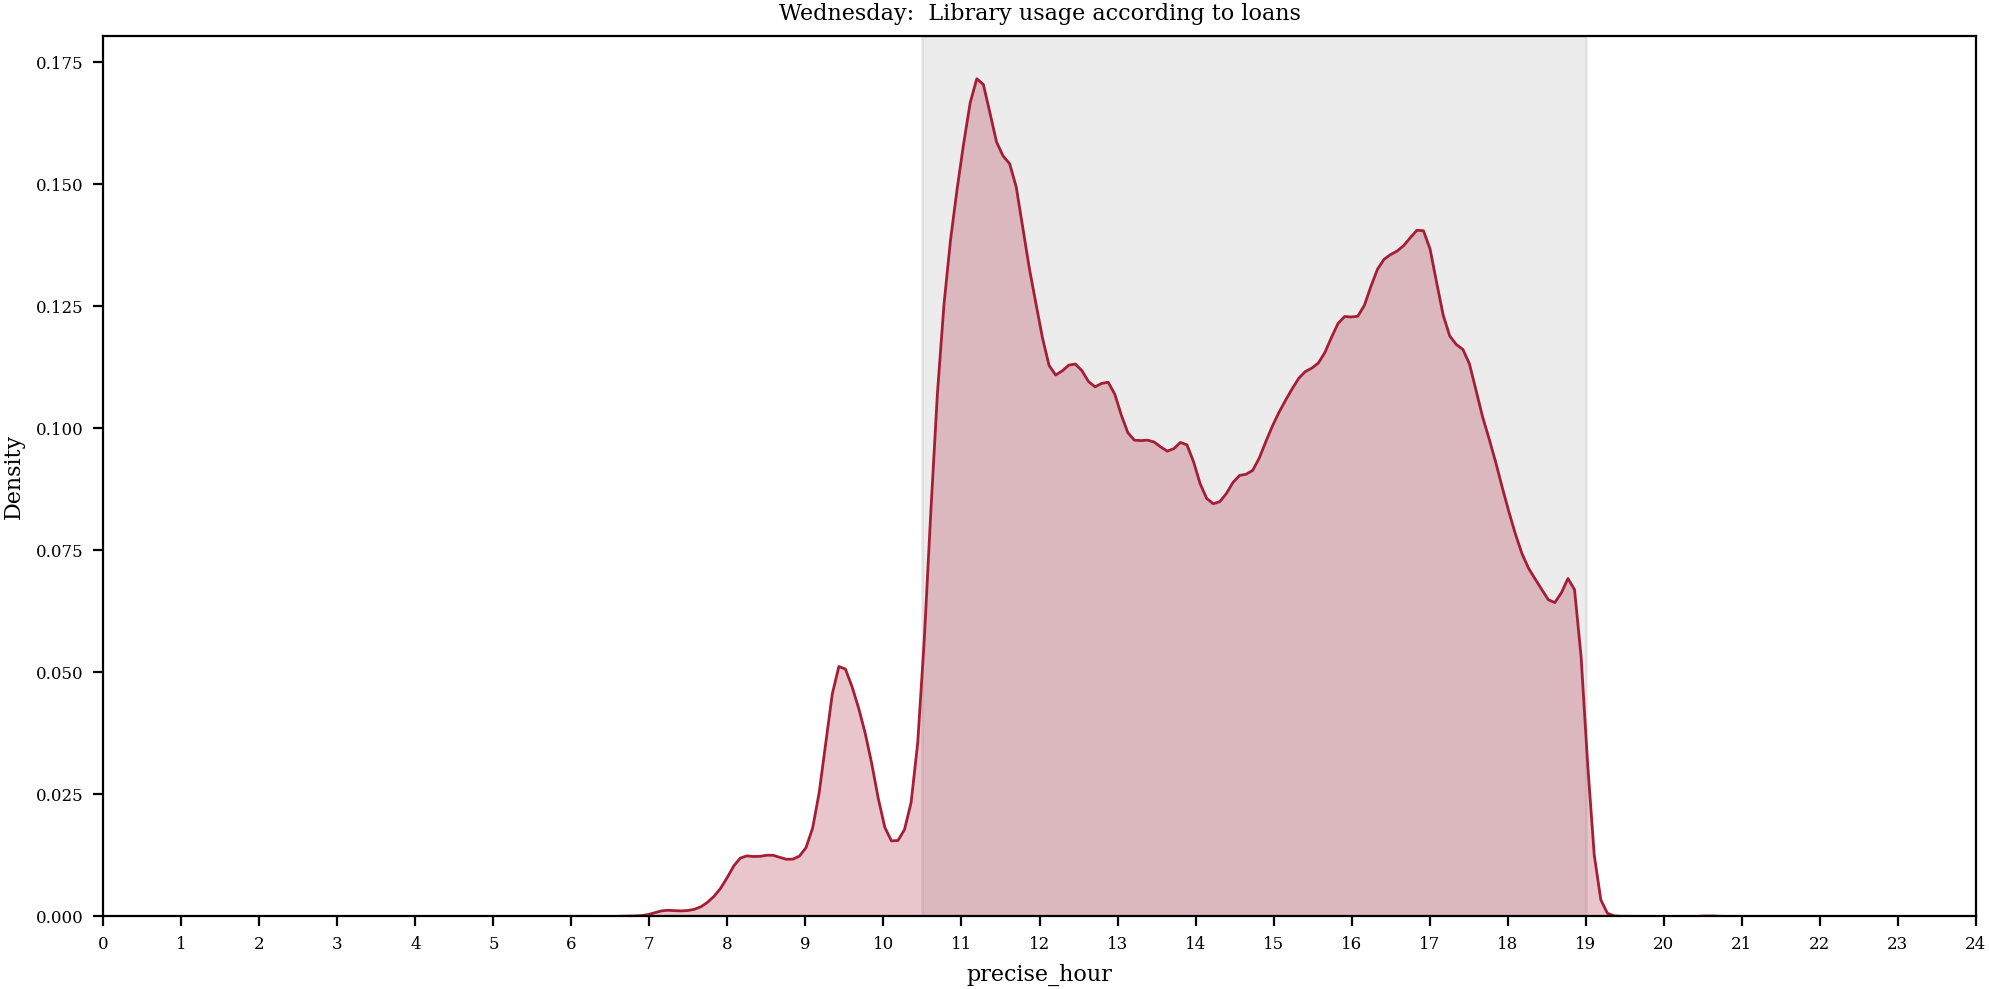

In [82]:

DAY = "Wednesday"
day_data = user_sessions_clean[user_sessions_clean["weekday"] == DAY]

plt.figure(figsize=(10, 5))
plt.axvspan(10.5, 19.0, color='gray', alpha=0.15, label='Official Opening Hours')

sns.kdeplot(
    data=day_data, 
    x="precise_hour", 
    fill=True, 
    bw_adjust=0.4, 
)

plt.xlim(0, 24)
plt.xticks(range(0, 25))
plt.title(f"{DAY}:  Library usage according to loans")
plt.show()

### Analysis of average loan time per user

In [83]:
# Calculate average time per user
user_time_behavior = user_sessions_clean.groupby(USER_ID_COL).agg({
    'precise_hour': ['mean', 'std', 'count'], 
    'weekday': lambda x: x.mode()[0] if not x.mode().empty else "Unknown" 
})
user_time_behavior.columns = ['avg_hour', 'hour_spread', 'visit_count', 'fav_day']

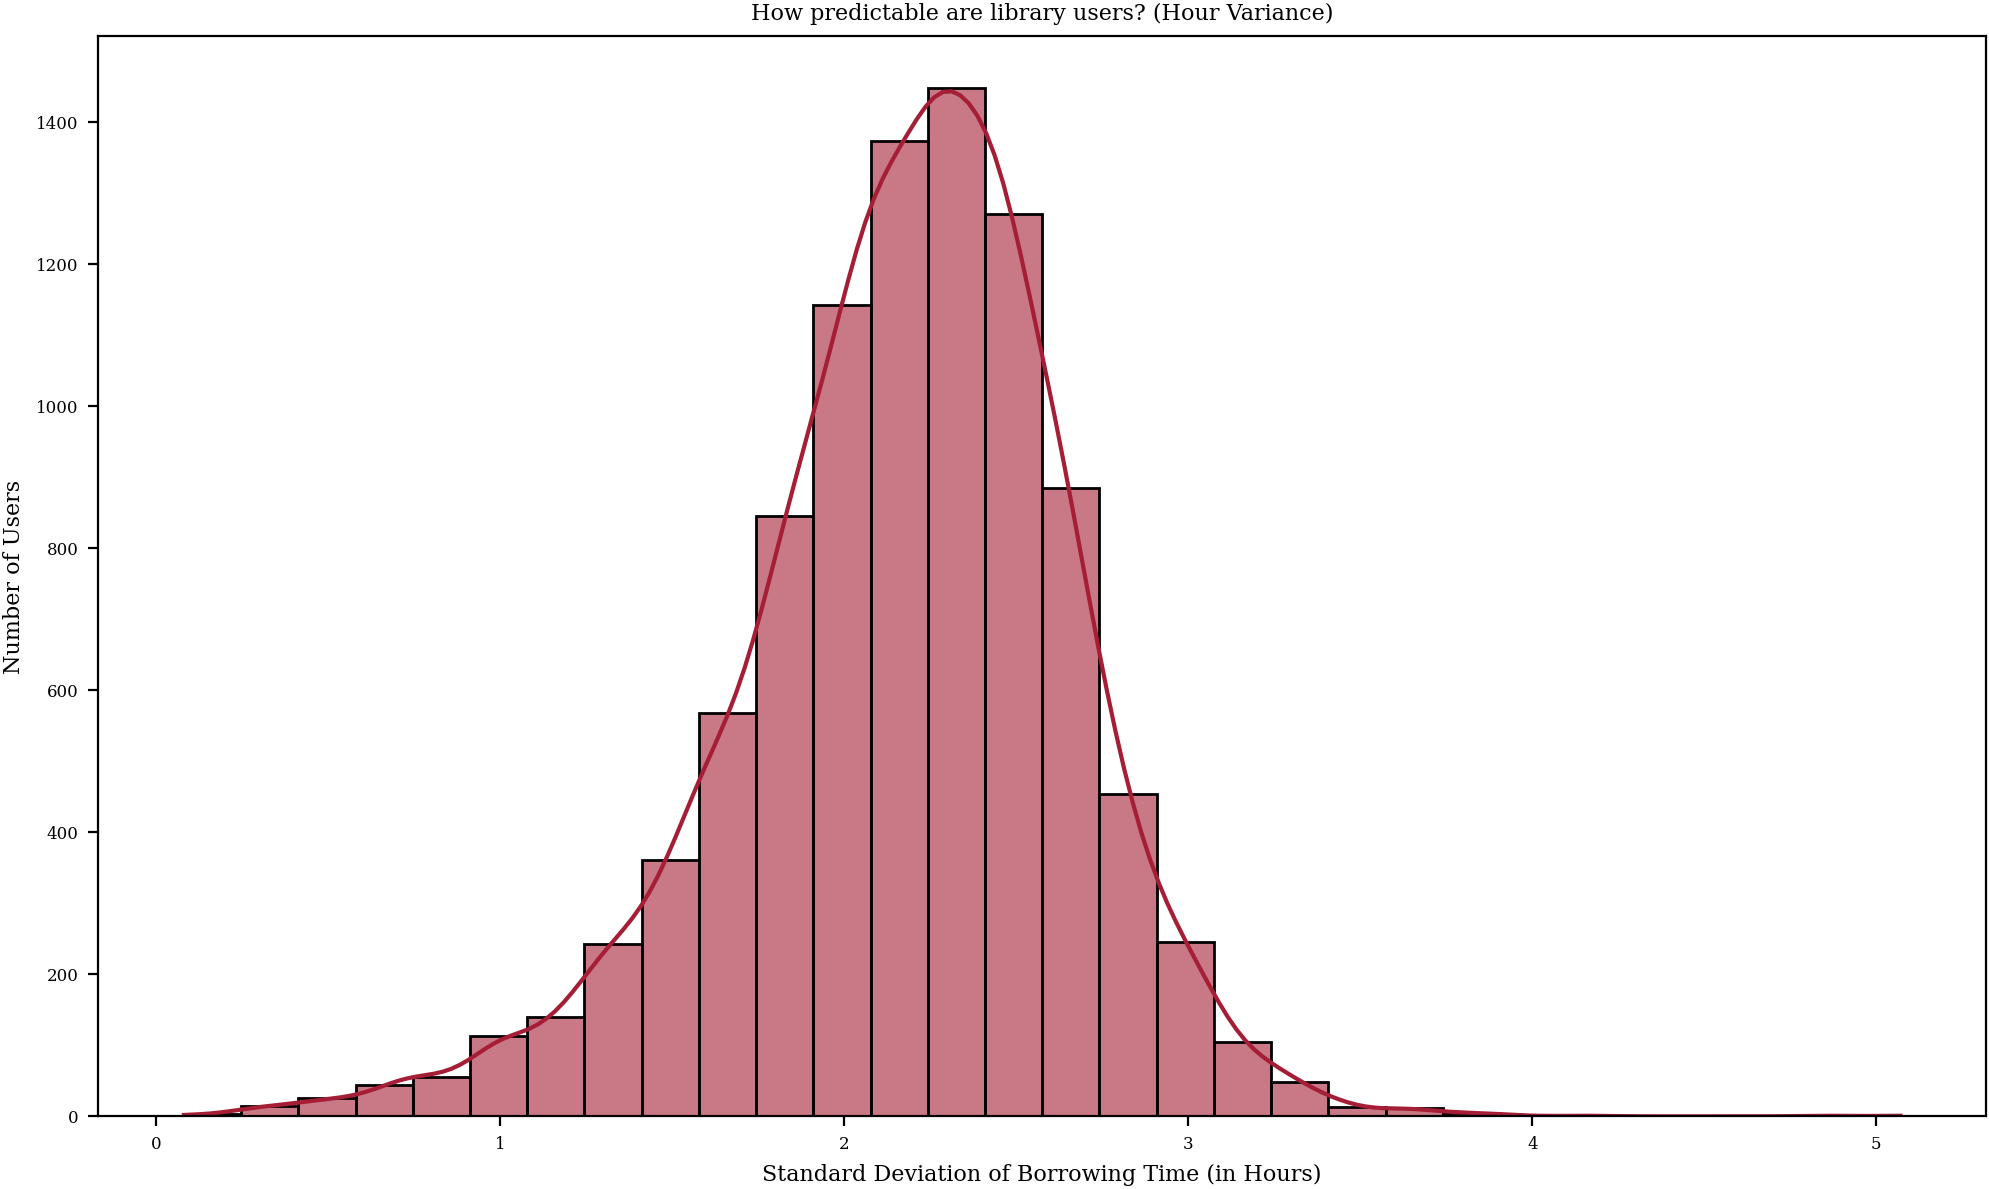

2.1% of users show high routine (±1 hour).
3.0% of users arrive at completely different times (>3h spread).


In [84]:
plt.figure(figsize=(10, 6))

sns.histplot(user_time_behavior['hour_spread'], bins=30, kde=True, alpha=0.6)

plt.title("How predictable are library users? (Hour Variance)")
plt.xlabel("Standard Deviation of Borrowing Time (in Hours)")
plt.ylabel("Number of Users")
plt.show()

low_var = (user_time_behavior['hour_spread'] <= 1.0).sum() / len(user_time_behavior['hour_spread']) * 100
high_var = (user_time_behavior['hour_spread'] > 3.0).sum() / len(user_time_behavior['hour_spread']) * 100

print(f"{low_var:.1f}% of users show high routine (±1 hour).")
print(f"{high_var:.1f}% of users arrive at completely different times (>3h spread).")

### How does the standard deviation behave over the day? 

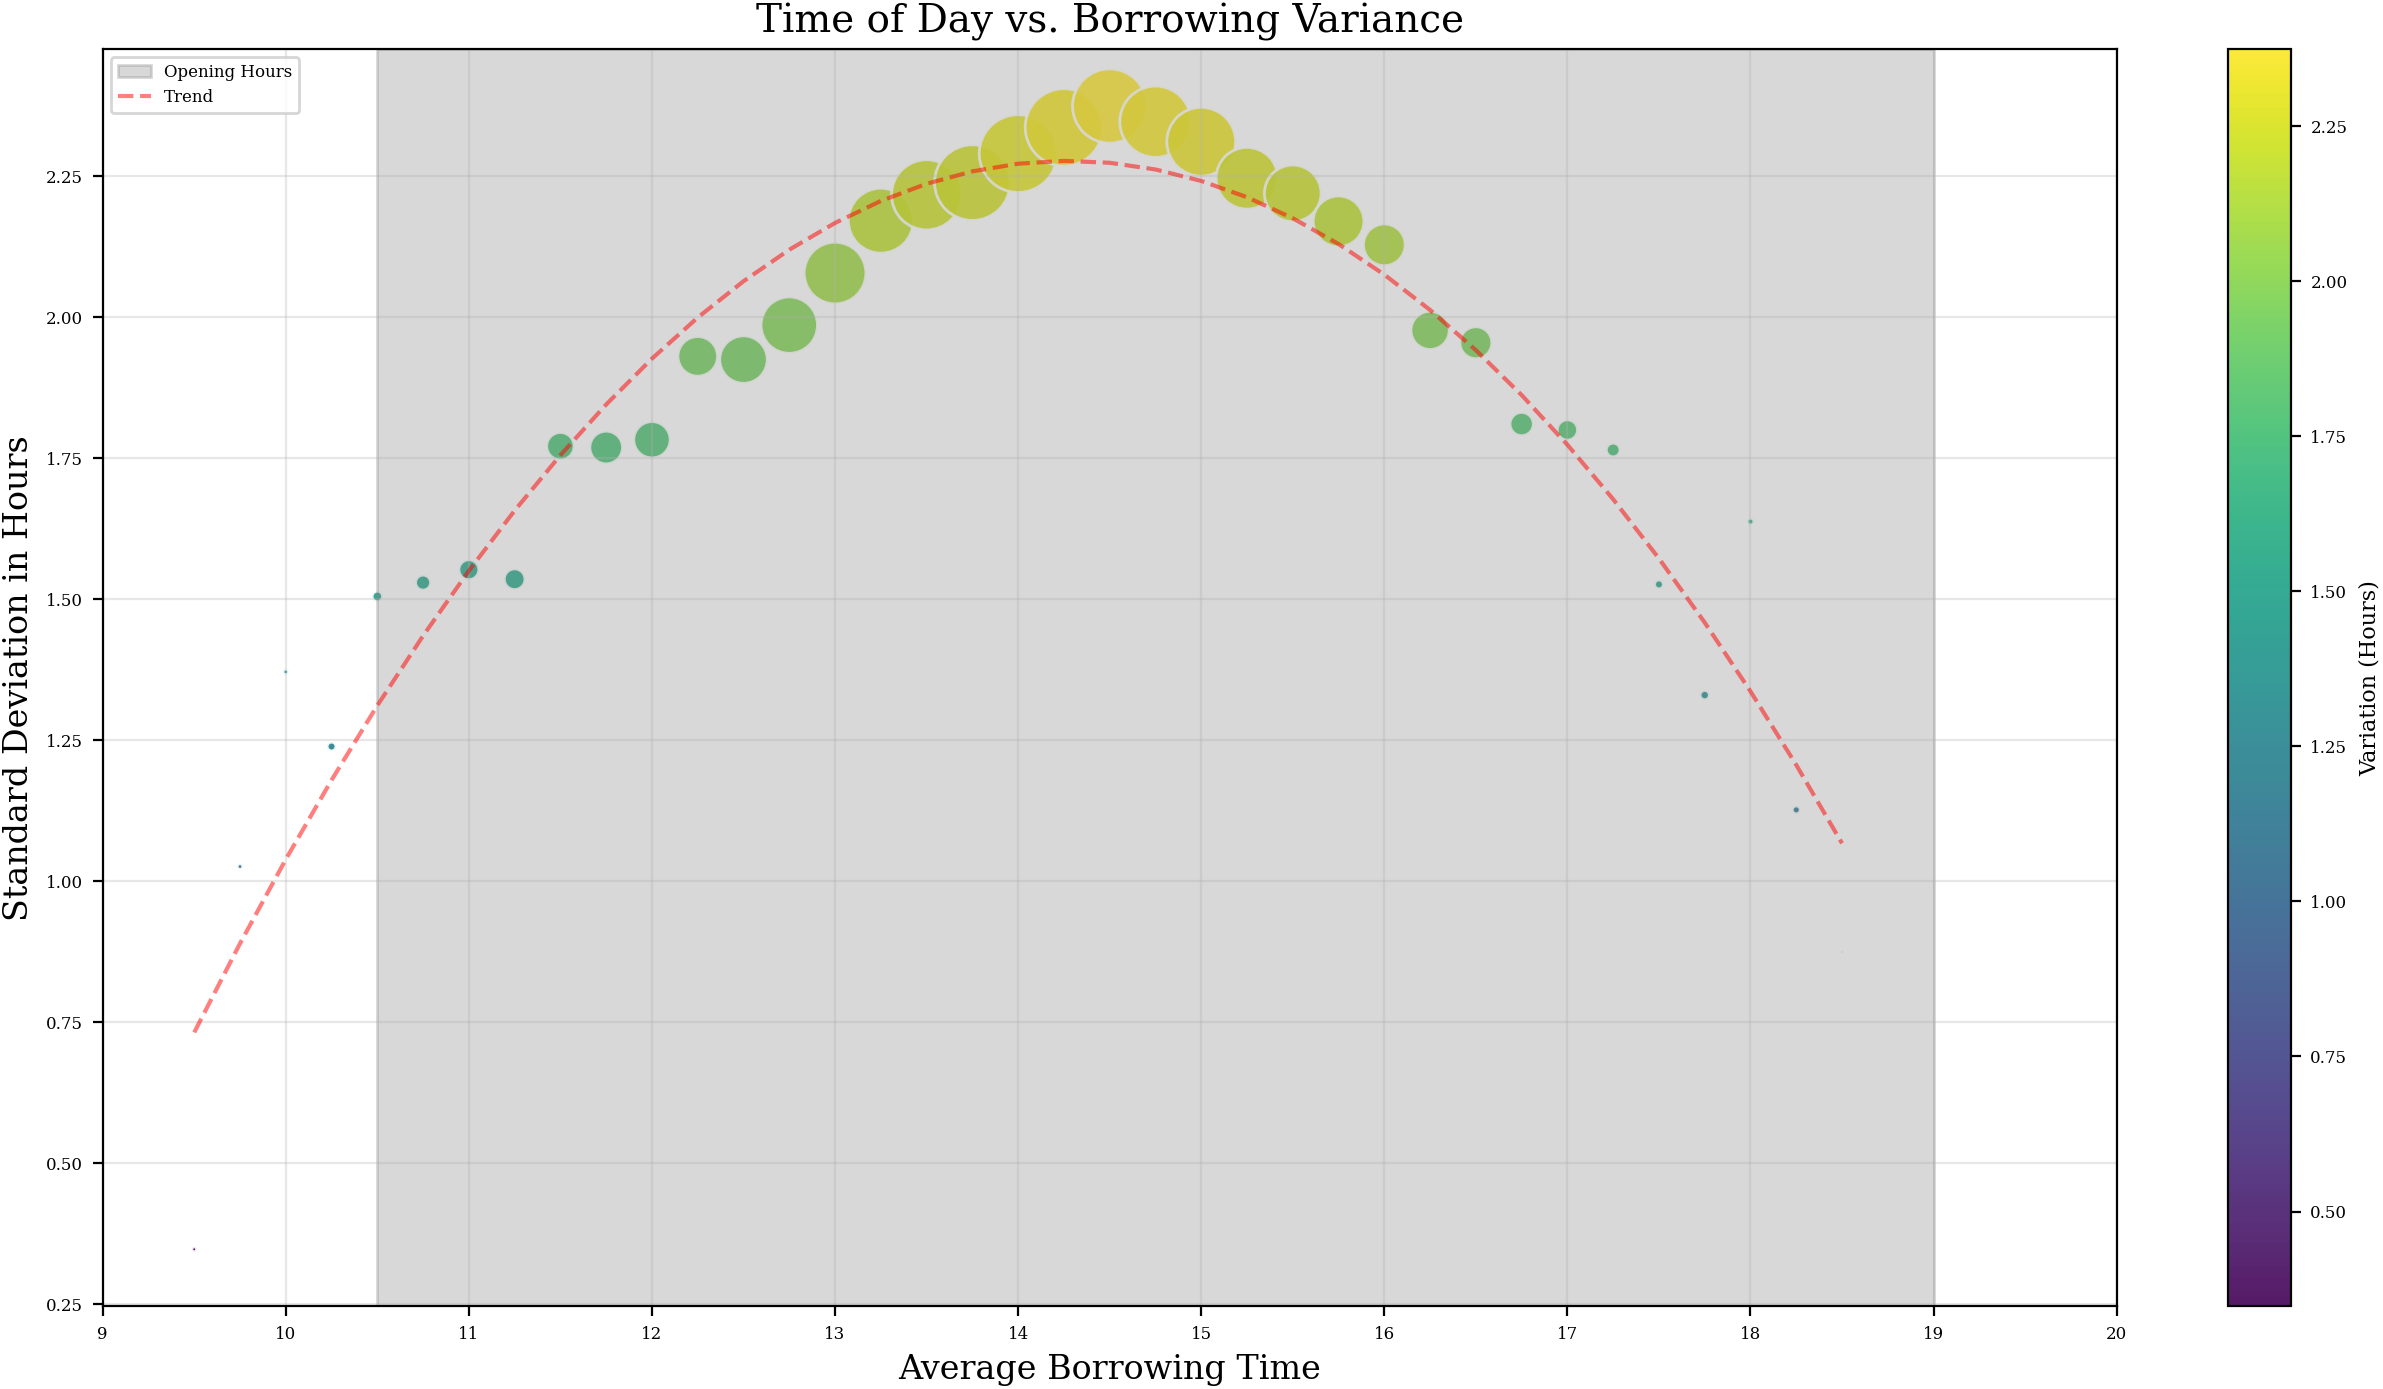

In [85]:
# Round average hour to 15-minute intervals
user_time_behavior['hour_bin'] = (user_time_behavior['avg_hour'] * 4).round() / 4

# Aggregate by time bin
stability_map = user_time_behavior.groupby('hour_bin').agg({
    'hour_spread': 'mean',
    'visit_count': 'count'
}).reset_index()

# Filter for relevant operational hours
stability_map = stability_map[(stability_map['hour_bin'] >= 6) & (stability_map['hour_bin'] <= 22)]

plt.figure(figsize=(12, 7))

# size = user volume, color = variance
scatter = plt.scatter(
    x=stability_map['hour_bin'],
    y=stability_map['hour_spread'],
    s=stability_map['visit_count'],
    c=stability_map['hour_spread'],
    cmap='viridis',
    alpha=0.9,
    edgecolors='w'
)

plt.axvspan(10.5, 19.0, color='gray', alpha=0.3, label='Opening Hours')

z = np.polyfit(stability_map['hour_bin'], stability_map['hour_spread'], 2)
p = np.poly1d(z)
plt.plot(stability_map['hour_bin'], p(stability_map['hour_bin']), "r--", alpha=0.5, label='Trend')

plt.title("Time of Day vs. Borrowing Variance", fontsize=14)
plt.xlabel("Average Borrowing Time", fontsize=12)
plt.ylabel("Standard Deviation in Hours", fontsize=12)
plt.xticks(range(9, 21))
plt.grid(axis='both', alpha=0.3)
plt.colorbar(scatter, label='Variation (Hours)')
plt.legend()

plt.show()

## User segmentation: Combining the two findings: consistency in the day (how confidently does a user visit on the same day) and how high is the Standard Deviation of borrowing time

9417


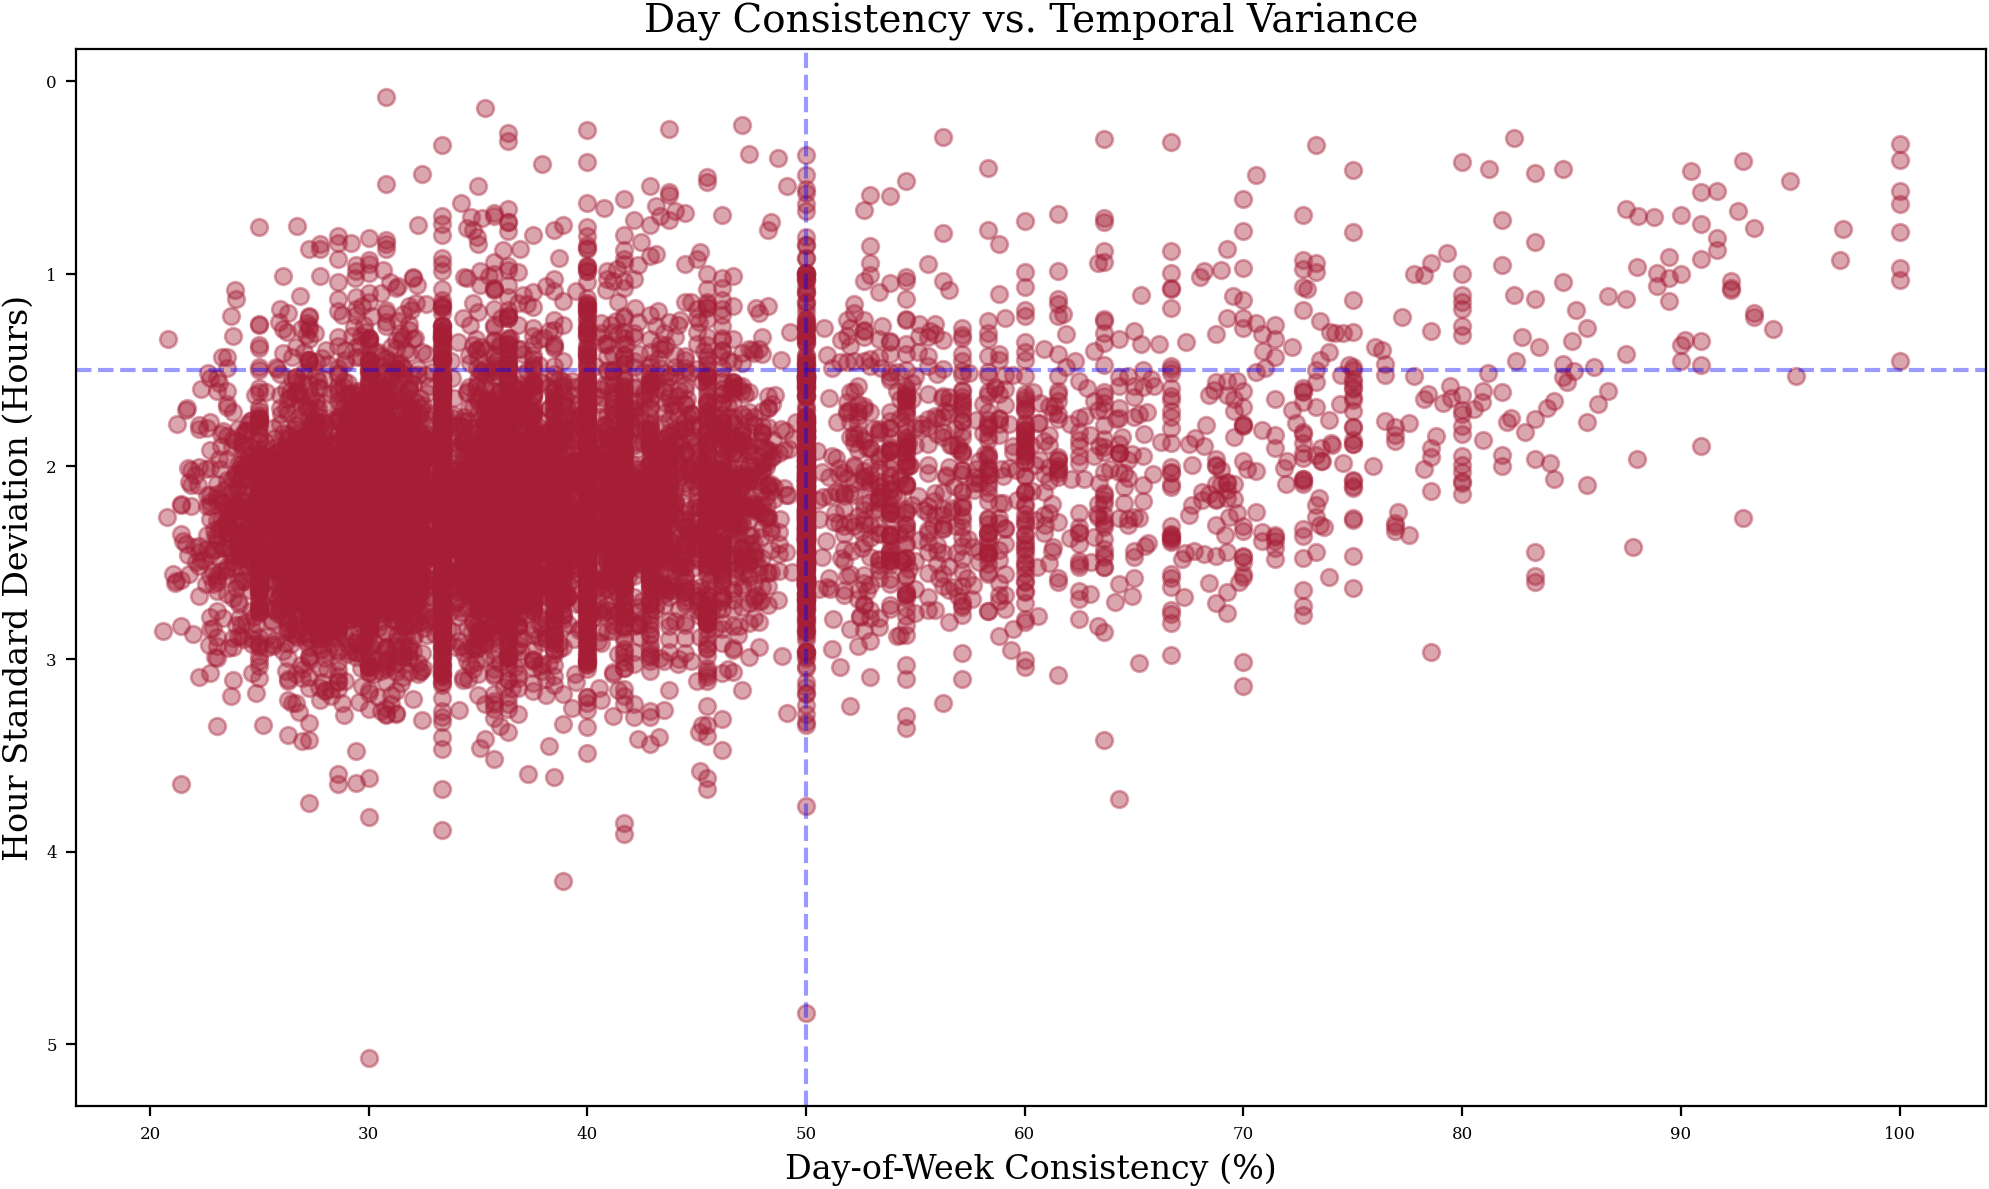

In [86]:

cluster_df = user_time_behavior[['avg_hour', 'hour_spread', 'visit_count']].copy()
cluster_df = user_time_behavior[user_time_behavior['visit_count'] >= MIN_SESSIONS].copy()
cluster_df['day_consistency'] = day_consistency 

print(len(cluster_df))

plt.figure(figsize=(10, 6))

scatter = plt.scatter(
    x=cluster_df['day_consistency'], 
    y=cluster_df['hour_spread'],
    alpha=0.4
)

plt.axvline(x=50, color='blue', linestyle='--', alpha=0.4) # 50% Day-Consistency
plt.axhline(y=1.5, color='blue', linestyle='--', alpha=0.4) # 1.5h Standard Deviation

plt.title("Day Consistency vs. Temporal Variance", fontsize=14)
plt.xlabel("Day-of-Week Consistency (%)", fontsize=12)
plt.ylabel("Hour Standard Deviation (Hours)", fontsize=12)
plt.gca().invert_yaxis() 
                         
plt.show()

In [87]:

day_threshold = 50
time_threshold = 1.5

total_users = len(cluster_df)

top_right = cluster_df[(cluster_df['day_consistency'] >= day_threshold) & (cluster_df['hour_spread'] <= time_threshold)]
bottom_right = cluster_df[(cluster_df['day_consistency'] >= day_threshold) & (cluster_df['hour_spread'] > time_threshold)]
top_left = cluster_df[(cluster_df['day_consistency'] < day_threshold) & (cluster_df['hour_spread'] <= time_threshold)]
bottom_left = cluster_df[(cluster_df['day_consistency'] < day_threshold) & (cluster_df['hour_spread'] > time_threshold)]

# Print results
print(f"Total Users (n >= {MIN_SESSIONS}): {total_users}\n")
print(f"1. Top Right:    {len(top_right)} ({len(top_right)/total_users:.1%})")
print(f"2. Bottom Right: {len(bottom_right)} ({len(bottom_right)/total_users:.1%})")
print(f"3. Top Left:  {len(top_left)} ({len(top_left)/total_users:.1%})")
print(f"4. Bottom Left:   {len(bottom_left)} ({len(bottom_left)/total_users:.1%})")

Total Users (n >= 10): 9417

1. Top Right:    302 (3.2%)
2. Bottom Right: 1250 (13.3%)
3. Top Left:  515 (5.5%)
4. Bottom Left:   7350 (78.1%)
